# Introduction 

This builds a basic VAMPnets model without the deeptime module. The resulting output will still be put in a deptime VAMP model to compare to the deeptime version. 

In [23]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from addict import Dict

from deeptime.util.types import to_dataset
from deeptime.decomposition import VAMP
from deeptime.decomposition.deep import VAMPNet

## Functions

In [35]:
def create_lobes(input_dim, device, output_dim): 
    lobe = nn.Sequential(
        nn.BatchNorm1d(input_dim), 
        nn.Linear(input_dim, 30), nn.ELU(),
        nn.Linear(30, 100), nn.ELU(),
        nn.Linear(100, 100), nn.ELU(),
        nn.Linear(100, 100), nn.ELU(),
        nn.Linear(100, 100), nn.ELU(),
        nn.Linear(100, 100), nn.ELU(),
        nn.Linear(100, 100), nn.ELU(),
        nn.Linear(100, 30), nn.ELU(),
        nn.Linear(30, output_dim),
        nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
    )
    
    lobe_timelagged = deepcopy(lobe).to(device=device)
    lobe = lobe.to(device=device)
    lobes = Dict(
        t0 = lobe, 
        tt = lobe_timelagged
    )
    return lobes


def deeptime_model(device, train_data, val_data, lobes, config):

    estimator = VAMPNet(lobe=lobes.t0, lobe_timelagged=lobes.tt, 
                        learning_rate=config.lr, device=device)
    loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
    loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False) 
    model = estimator.fit(loader_train, n_epochs=config.n_epochs,
                    validation_loader=loader_val).fetch_model()
    return estimator, model 

def its(model, config):
    lagtimes = np.arange(1, 201, dtype=np.int32)
    timescales = []
    for lag in lagtimes:
        ts = VAMP(lagtime=lag, observable_transform=model).fit(data).fetch_model().timescales(k=config.output_dim-1)
        timescales.append(ts)
    return lagtimes, timescales

## Get GPU

In [31]:
assert torch.cuda.is_available(), "Need a GPU with CUDA" 
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

## Paths

In [25]:
data_dir = "/home/rob/online_vampnets/data"
coordinates_path = Path(data_dir).joinpath('alanine-dipeptide-3x250ns-heavy-atom-positions.npz')
dihedrals_path = Path(data_dir).joinpath('alanine-dipeptide-3x250ns-backbone-dihedrals.npz')

## Load data

In [16]:
with np.load(coordinates_path.open('rb')) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

with np.load(dihedrals_path.open('rb')) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

## Configuration

In [29]:
config = Dict(lag_time = 1, 
              validation_split = 0.3, 
              input_dim = int(data[0].shape[1]), 
              output_dim = 6, 
              lr = 5e-4, 
              n_epochs = 30)

In [ ]:
dataset = to_dataset(data=data, lagtime=config.lag_time)
n_val = int(len(dataset)*config.validation_split)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

## Deeptime model


In [36]:
lobes = create_lobes(config.input_dim, device, config.output_dim)
dt_est, dt_mod = deeptime_model(device, train_data, val_data, lobes, config)
dt_its = its(dt_mod, config)

In [37]:
## Celerity model

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

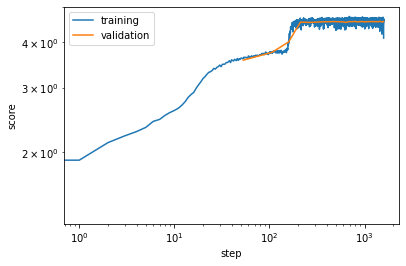

In [63]:
# plt.loglog(*vampnet.train_scores.T, label='training')
# plt.loglog(*vampnet.validation_scores.T, label='validation')
# plt.xlabel('step')
# plt.ylabel('score')
# plt.legend();



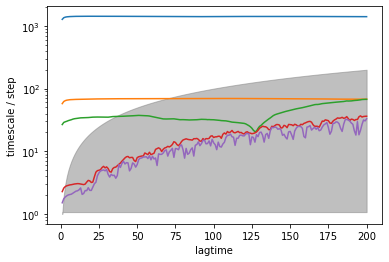

In [69]:


# f, ax = plt.subplots(1, 1)
# ax.semilogy(lagtimes, timescales)
# ax.set_xlabel('lagtime')
# ax.set_ylabel('timescale / step')
# ax.fill_between(lagtimes, ax.get_ylim()[0]*np.ones(len(lagtimes)), lagtimes, alpha=0.5, color='grey')

In [71]:
# vamp_estimator = VAMP(lagtime=1, observable_transform=model)
# vamp = vamp_estimator.fit(data).fetch_model()

# validator = vamp_estimator.chapman_kolmogorov_validator(mlags=20)
# cktest = validator.fit(data, n_jobs=1).fetch_model()

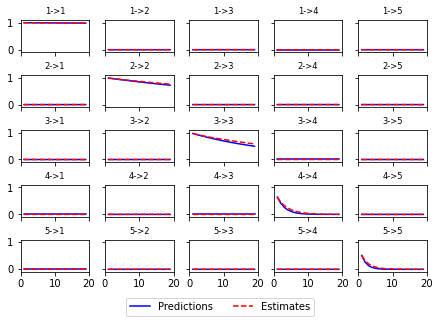

In [73]:
# n_states = len(vamp.singular_values)

# tau = cktest.lagtimes[1]
# steps = len(cktest.lagtimes)
# fig, ax = plt.subplots(n_states, n_states, sharex=True, sharey=True, constrained_layout=True)
# for i in range(n_states):
#     for j in range(n_states):
#         pred = ax[i][j].plot(cktest.lagtimes, cktest.predictions[:, i, j], color='b')
#         est = ax[i][j].plot(cktest.lagtimes, cktest.estimates[:, i, j], color='r', linestyle='--')
#         ax[i][j].set_title(str(i+1)+ '->' +str(j+1),
#                                        fontsize='small')
# ax[0][0].set_ylim((-0.1,1.1));
# ax[0][0].set_xlim((0, steps*tau));
# ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 3)));
# fig.legend([pred[0], est[0]], ["Predictions", "Estimates"], 'lower center', ncol=2,
#            bbox_to_anchor=(0.5, -0.1));